# ConvLSTM model

Import libraries and modules.

In [1]:
%cd ..
%cd ..
# move to the root directory of the git

C:\Users\Admin\Documents\GitHub\FLOOD_project\models
C:\Users\Admin\Documents\GitHub\FLOOD_project


In [2]:
import importlib
import torch
import copy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch.nn as nn

# Enable interactive widgets in Jupyter Notebook
%matplotlib widget

# import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from mpl_toolkits.axes_grid1 import make_axes_locatable

from models.ConvLSTM_model.ConvLSTM_pytorch.convlstm import ConvLSTM
from models.ConvLSTM_model.train_eval import train_epoch_conv_lstm, evaluation_conv_lstm
from pre_processing.encode_decode_csv import decode_from_csv
from pre_processing.normalization import * 
from post_processing.cool_animation import plot_animation
from post_processing.plots import plot_losses

In [3]:
# importlib.reload(convlstm)

In [4]:
# model save path
save_path = 'models/ConvLSTM_model/conv_lstm_4batch_16hidden_3kernel.pth'

Check if GPU is available.

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


The following lines create variables to more easily specify what we use the model for (i.e., train and validate, test with dataset 1 and so on) in the following functions.

In [6]:
train_val = 'train_val'
test1 = 'test1'
test2 = 'test2'
test3 = 'test3'

Load data from decoder.

**Please note**: 
\
inputs and targets in <code>train_val</code> are stored not in the original manner. 

index 0 = 1, index 1 = 10, index 11 = 2, index 12 = 20 etc.

In [7]:
# training and validation dataset
train_dataset = decode_from_csv(train_val)

Restored inputs Shape: torch.Size([80, 1, 4, 64, 64])
Restored targets Shape: torch.Size([80, 48, 2, 64, 64])


In [8]:
# first position is the samples, second decides between inputs or targets, notice new shape of inputs
train_dataset[0][0].shape

torch.Size([1, 4, 64, 64])

Text(0.5, 1.0, 'Water Depth time step 0')

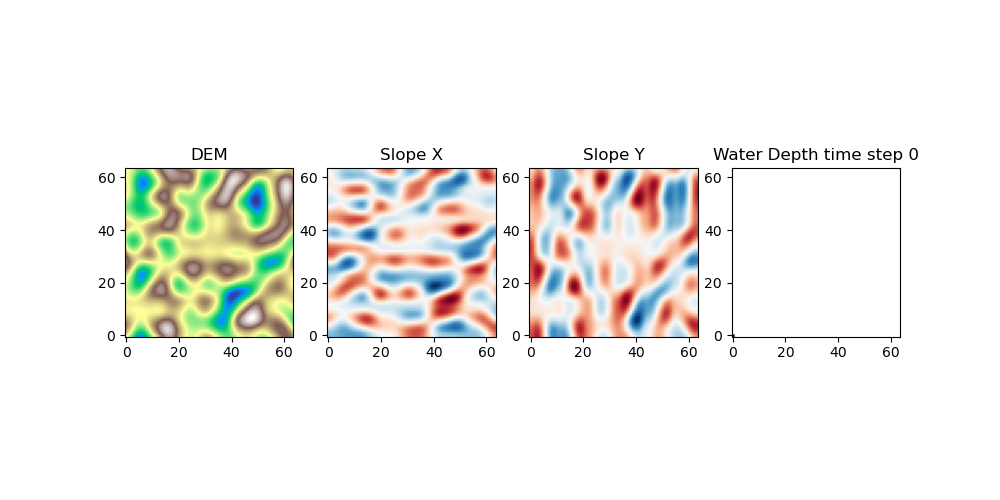

In [9]:
# From FAT application
fig, axs = plt.subplots(1, 4, figsize=(10, 5))

# specify which entry of the dataset to plot
numb = 0

axs[0].imshow(train_dataset[numb][0][0][0].cpu(), cmap='terrain', origin='lower')
axs[0].set_title('DEM')

axs[1].imshow(train_dataset[numb][0][0][1].cpu(), cmap='RdBu', origin='lower')
axs[1].set_title('Slope X')

axs[2].imshow(train_dataset[numb][0][0][2].cpu(), cmap='RdBu', origin='lower')
axs[2].set_title('Slope Y')

axs[3].imshow(train_dataset[numb][0][0][3].cpu(), cmap='binary', origin='lower')
axs[3].set_title('Water Depth time step 0')

In [10]:
# Normalize the inputs and outputs using training dataset
scaler_x, scaler_wd, scaler_q = scaler(train_dataset)

normalized_train_dataset = normalize_dataset(train_dataset, scaler_x, scaler_wd, scaler_q)

In [11]:
# Split dataset into train and validation
train_percnt = 0.8
train_size = int(train_percnt * len(train_dataset))
val_size = len(train_dataset) - train_size
train_set, val_set = random_split(normalized_train_dataset, [train_size, val_size])

In [12]:
type(train_set[0][1].shape[1])

int

In [13]:
# Model
model = ConvLSTM(input_dim = train_set[0][0].shape[1], output_dim = train_set[0][1].shape[1], hidden_dim = 16, kernel_size = (3, 3),
                 num_layers = train_set[0][1].shape[0], batch_first=True, bias=True, return_all_layers = True).to(device)
# return all layers has to be true to obtain all the outputs I think
# num_layers refers to the number of cells and thus outputs
# Number of outputs = 4 gates * hidden_dim

In [14]:
model

ConvLSTM(
  (conv2): Conv2d(16, 2, kernel_size=(1, 1), stride=(1, 1))
  (cell_list): ModuleList(
    (0): ConvLSTMCell(
      (conv): Conv2d(20, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-47): 47 x ConvLSTMCell(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
)

In [15]:
# Set training parameters
learning_rate = 0.001
batch_size = 4 # Only have 64 and 16 samples for training and validation, I think should be kept small, having issues where this only works if set to 1
num_epochs = 8_000

# Create the optimizer to train the neural network via back-propagation
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# Create the training and validation dataloaders to "feed" data to the model in batches
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

In [16]:
train_losses = []
val_losses = []

for epoch in range(1, num_epochs+1):
    # Model training
    train_loss = train_epoch_conv_lstm(model, train_loader, optimizer, device=device)

    # Model validation
    val_loss = evaluation_conv_lstm(model, val_loader, device=device)

    if epoch == 1:
        best_loss = val_loss
    
    if val_loss<=best_loss:
        best_model = copy.deepcopy(model)
        best_loss = val_loss
        best_epoch = epoch

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if epoch%100 == 0:
        print(f"epoch: {epoch} \t training loss: {train_loss: .2e} \t validation loss: {val_loss: .2e}")

epoch: 100 	 training loss:  2.67e-03 	 validation loss:  2.75e-03
epoch: 200 	 training loss:  1.96e-03 	 validation loss:  1.98e-03
epoch: 300 	 training loss:  1.50e-03 	 validation loss:  1.55e-03
epoch: 400 	 training loss:  1.60e-03 	 validation loss:  1.76e-03
epoch: 500 	 training loss:  1.12e-03 	 validation loss:  1.15e-03
epoch: 600 	 training loss:  9.29e-04 	 validation loss:  9.69e-04
epoch: 700 	 training loss:  8.53e-04 	 validation loss:  9.06e-04
epoch: 800 	 training loss:  7.78e-04 	 validation loss:  8.22e-04
epoch: 900 	 training loss:  7.13e-04 	 validation loss:  7.43e-04
epoch: 1000 	 training loss:  6.91e-04 	 validation loss:  7.22e-04
epoch: 1100 	 training loss:  6.23e-04 	 validation loss:  6.56e-04
epoch: 1200 	 training loss:  5.95e-04 	 validation loss:  6.19e-04
epoch: 1300 	 training loss:  7.48e-04 	 validation loss:  7.85e-04
epoch: 1400 	 training loss:  5.12e-04 	 validation loss:  5.36e-04
epoch: 1500 	 training loss:  4.83e-04 	 validation loss:

In [17]:
model = copy.deepcopy(best_model)
torch.save(model.state_dict(), save_path)

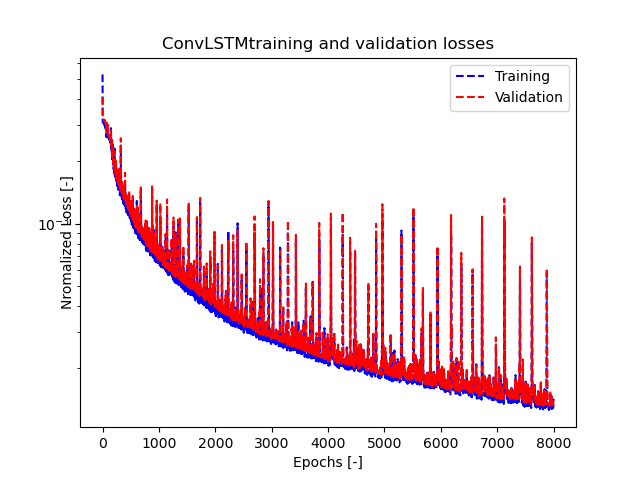

In [18]:
plot_losses(train_losses, val_losses, 'ConvLSTM')

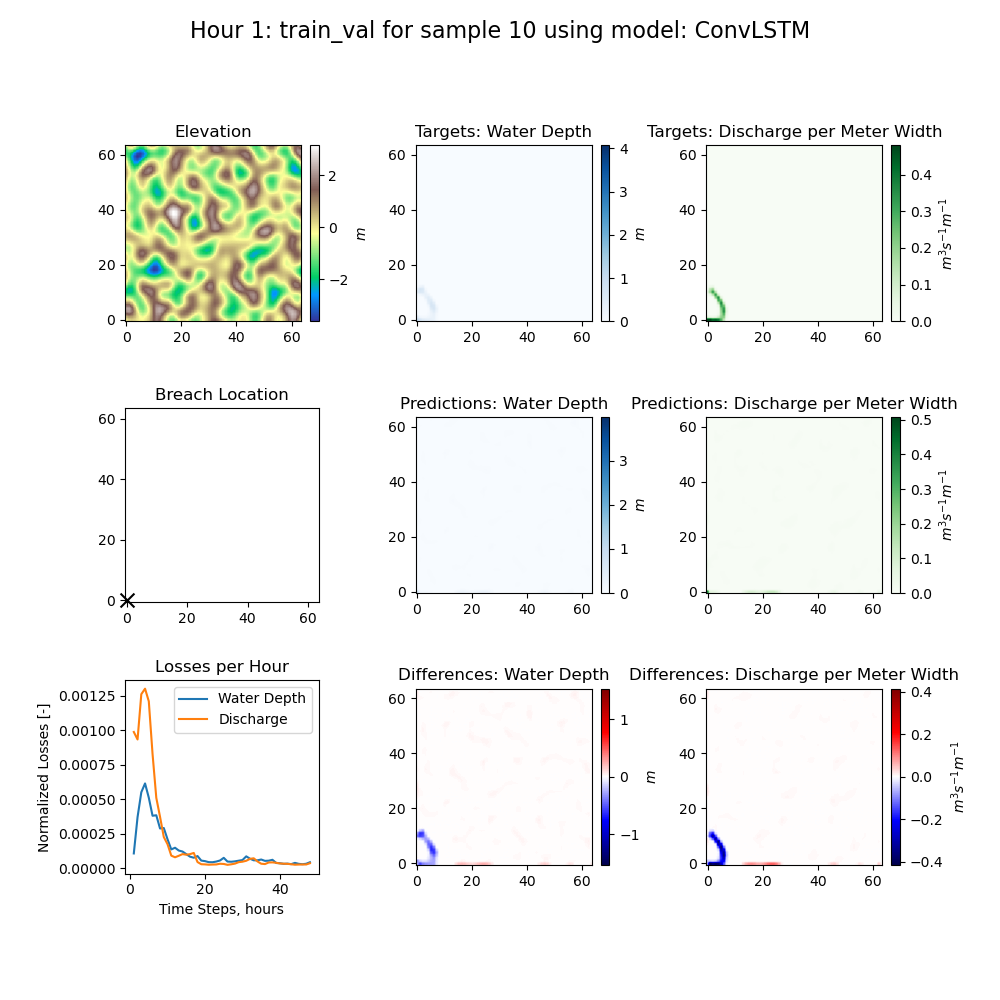

MovieWriter Pillow unavailable; using Pillow instead.


In [19]:
plot_animation(10, normalized_train_dataset, model, train_val,
               scaler_x, scaler_wd, scaler_q, device = device, save = False)